In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import json
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
import os
import matplotlib.pyplot as plt

In [3]:
def print_info(results, name):
    plus_minus = np.std(results) / np.sqrt(len(results)) * 1.96
    mean = np.mean(results)
    print(f'Mean of {name}: {round(mean,2)} and 95% CI: [{round(mean-plus_minus,2)}, {round(mean+plus_minus,2)}]')
    f.write(f'Mean of {name}: {round(mean,2)} and 95% CI: [{round(mean-plus_minus,2)}, {round(mean+plus_minus,2)}]\n')

number of sentences:  1016 for:  faks_hierarhical_ELMO
Mean of random_baseline_loss: 0.87 and 95% CI: [0.86, 0.89]
Mean of baseline_loss: 0.47 and 95% CI: [0.46, 0.48]
Mean of loss: 0.04 and 95% CI: [0.03, 0.04]
Mean of random_CA: 0.5 and 95% CI: [0.49, 0.51]
Mean of baseline_CA: 0.82 and 95% CI: [0.82, 0.83]
Mean of CA: 0.98 and 95% CI: [0.98, 0.99]
number of sentences:  1016 for:  faks_hierarhical_fasttext
Mean of random_baseline_loss: 0.88 and 95% CI: [0.86, 0.89]
Mean of baseline_loss: 0.34 and 95% CI: [0.33, 0.35]
Mean of loss: 0.11 and 95% CI: [0.1, 0.13]
Mean of random_CA: 0.49 and 95% CI: [0.48, 0.5]
Mean of baseline_CA: 0.89 and 95% CI: [0.89, 0.9]
Mean of CA: 0.96 and 95% CI: [0.96, 0.96]
number of sentences:  1253 for:  faks_hierarhical_sloBERTa
Mean of random_baseline_loss: 0.89 and 95% CI: [0.88, 0.91]
Mean of baseline_loss: 0.39 and 95% CI: [0.38, 0.4]
Mean of loss: 0.0 and 95% CI: [0.0, 0.0]
Mean of random_CA: 0.5 and 95% CI: [0.49, 0.5]
Mean of baseline_CA: 0.87 and 95%

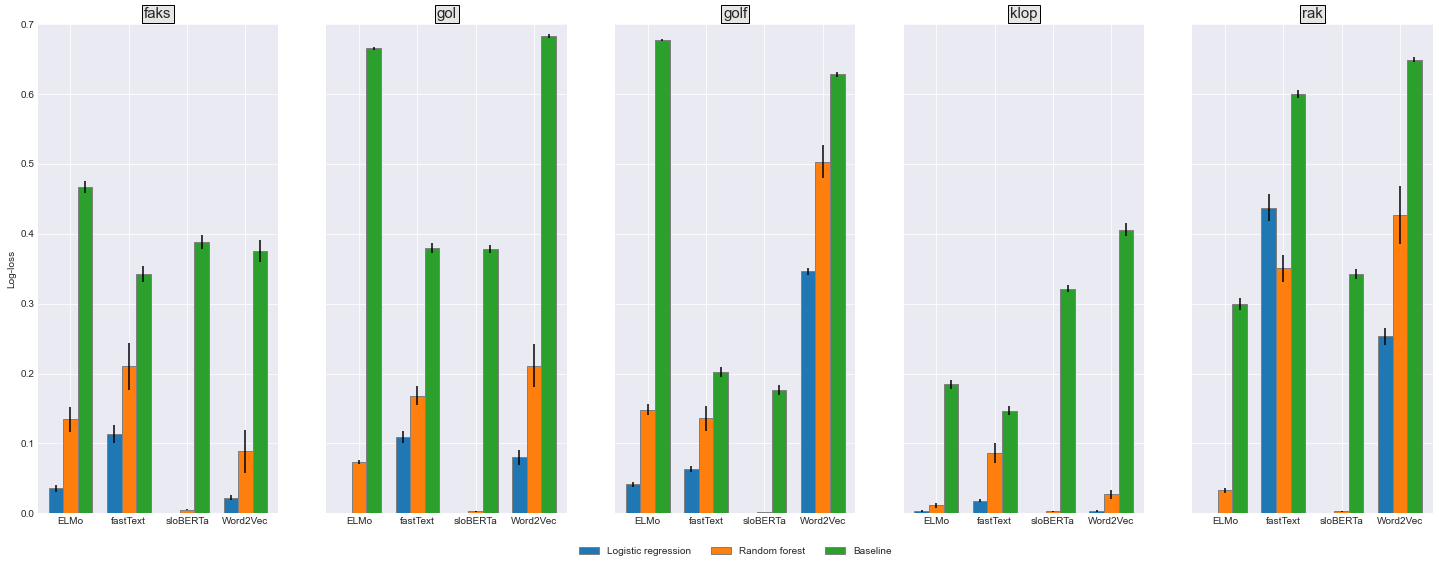

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(25,9), sharey=True)
plt.style.use('seaborn-darkgrid')
plt.set_cmap("plasma")

count = 0
words = ['faks', 'gol', 'golf', 'klop', 'rak']

for l, file in enumerate(os.listdir('./data')):

    if l%4 == 0:
        log_loss_mean = []
        log_loss_CI = []
        baseline_mean = []
        baseline_CI = []
        tree_loss_mean = []
        tree_CI = []

    file_name = file[:-4]
    f = open(f'results/{file_name}.txt', "a")

    df = pd.read_csv(f'data/{file_name}.csv')
    df_annotated = pd.read_csv(f'./annotated/{file_name}.csv')

    k = 5
    scaler = StandardScaler()

    X = df.iloc[:,:-1].values
    y = df.iloc[:,-1].values

    X_annotated = df_annotated.iloc[:,1:-1].values
    y_annotated = df_annotated.iloc[:,-1].values


    loss = []
    baseline_loss = []
    random_baseline_loss = []
    ca = []
    baseline_ca = []
    random_ca = []
    annotated_loss = []
    annotated_ca = []

    tree_loss = []

    print("number of sentences: ", len(X), "for: ", file_name)
    for j in range(10):

        kfold = KFold(k, shuffle=True, random_state=j)
        splits = kfold.split(X)
        
        
        for i in range(k):
            # print(i)
            split = next(splits, None)
            X_cross_train = X[split[0]]
            X_cross_test = X[split[1]]
            y_cross_train = y[split[0]]
            y_cross_test = y[split[1]]
            X_cross_train = scaler.fit_transform( X_cross_train )
            X_cross_test = scaler.transform( X_cross_test )

            clf = LogisticRegression(random_state=i).fit(X_cross_train, y_cross_train)
            predictions = clf.predict_proba(X_cross_test)
            pred = clf.predict(X_cross_test)

            rf = RandomForestClassifier(n_estimators = 10, random_state = i)
            rf.fit(X_cross_train, y_cross_train)
            predictions2 = rf.predict_proba(X_cross_test)
            pred2 = rf.predict(X_cross_test)

            zeros = len(y_cross_test[y_cross_test==0])
            ones = len(y_cross_test[y_cross_test==1])
            both = zeros + ones

            if zeros == 0 or ones == 0:
                print("error")
                continue

            baseline_loss.append(log_loss(y_cross_test, np.hstack((np.array([zeros/both]*both).reshape(-1, 1),np.array([ones/both]*both).reshape(-1, 1)))))
            random_baseline_loss.append(log_loss(y_cross_test, np.random.random([len(y_cross_test),2])))
            loss.append(log_loss(y_cross_test, predictions))

            baseline_ca.append(len(y_cross_test[y_cross_test==stats.mode(y_cross_test)[0][0]])/len(y_cross_test))
            random_ca.append(len(y_cross_test[y_cross_test==np.random.randint(0,2,len(y_cross_test))])/len(y_cross_test))
            ca.append(np.sum(pred==y_cross_test)/len(y_cross_test))

            tree_loss.append(log_loss(y_cross_test, predictions2))

            predictions = clf.predict_proba(X_annotated)
            pred = clf.predict(X_annotated)

            predictions = rf.predict_proba(X_annotated)
            pred = rf.predict(X_annotated)

            annotated_loss.append(log_loss(y_annotated, pred))
            annotated_ca.append(np.sum(pred==y_annotated)/len(y_annotated))

    print_info(random_baseline_loss, 'random_baseline_loss')
    print_info(baseline_loss, 'baseline_loss')
    print_info(loss, 'loss')
    print_info(random_ca, 'random_CA')
    print_info(baseline_ca, 'baseline_CA')
    print_info(ca, 'CA')

    print_info([np.mean(len(y_annotated[y_annotated==stats.mode(y_annotated)[0][0]])/len(y_annotated))], 'annotated baseline')
    print_info(annotated_loss, "annotated_loss")
    print_info(annotated_ca,"annotated_ca")

    log_loss_mean.append(np.mean(loss))
    log_loss_CI.append(np.std(loss) / np.sqrt(len(loss)) * 1.96)
    baseline_mean.append(np.mean(baseline_loss))
    baseline_CI.append(np.std(baseline_loss) / np.sqrt(len(baseline_loss)) * 1.96)
    tree_loss_mean.append(np.mean(tree_loss))
    tree_CI.append(np.std(tree_loss) / np.sqrt(len(tree_loss)) * 1.96)

    if l%4 == 3:
        # axs[count].errorbar(range(4), log_loss_mean, yerr=log_loss_CI, label='Log reg')
        # axs[count].errorbar(range(4), tree_loss_mean, yerr=tree_CI, label='random forest')
        # axs[count].errorbar(range(4), baseline_mean, yerr=baseline_CI, label='baseline')
        barWidth = 0.25
        br1 = range(4)
        br2 = [x + barWidth for x in br1]
        br3 = [x + barWidth for x in br2]
        axs[count].bar(br1, log_loss_mean, width = barWidth,
                edgecolor ='grey', label ='Logistic regression', yerr=log_loss_CI)
        axs[count].bar(br2, tree_loss_mean, width = barWidth,
                edgecolor ='grey', label ='Random forest', yerr=tree_CI)
        axs[count].bar(br3, baseline_mean, width = barWidth,
                edgecolor ='grey', label ='Baseline', yerr=baseline_CI)
        axs[count].set_xticks([r + barWidth for r in range(4)])
        axs[count].set_xticklabels(['ELMo', 'fastText', 'sloBERTa', 'Word2Vec'])
        axs[count].set_ylim(0,0.7)
        axs[count].set_title(words[count], fontsize=15, bbox={'facecolor':'0.9', 'pad':2})
        
        # plt.xl
        count += 1

    f.write("\n")

    f.close()
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
axs[0].set_ylabel("Log-loss")
plt.show()